# Лабаораторная работа №2: Классификация аудио

In [1]:
# !pip -q install datasets torchaudio torch torchvision scikit-learn transformers accelerate --upgrade

import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000


Device: cuda


In [2]:
!pip install torchcodec

In [3]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR))

def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00016-e478d7cccca6a0(…):   0%|          | 0.00/434M [00:00<?, ?B/s]

data/train-00001-of-00016-299138aa39afaa(…):   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00002-of-00016-887e0748205b6f(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

data/train-00003-of-00016-691ee48aa53d9c(…):   0%|          | 0.00/447M [00:00<?, ?B/s]

data/train-00004-of-00016-c0f37514d8e28a(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00005-of-00016-55ef1a0a51149c(…):   0%|          | 0.00/591M [00:00<?, ?B/s]

data/train-00006-of-00016-0ef363072505e6(…):   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00007-of-00016-dfac173beb21e5(…):   0%|          | 0.00/588M [00:00<?, ?B/s]

data/train-00008-of-00016-2744487f32f65d(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00009-of-00016-83fc7364d47981(…):   0%|          | 0.00/549M [00:00<?, ?B/s]

data/train-00010-of-00016-4c1d0e285ed778(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00011-of-00016-79d186503a2667(…):   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00012-of-00016-6aff88fdcca229(…):   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00013-of-00016-17d827b1a5be04(…):   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00014-of-00016-c630762df85f6c(…):   0%|          | 0.00/381M [00:00<?, ?B/s]

data/train-00015-of-00016-03506887d89adf(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

(7079, 816, 837, 10)

In [4]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


In [6]:
class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

history = {
    "tr_loss": [], "tr_acc": [],
    "va_loss": [], "va_acc": [],
    "tr_f1": [], "va_f1": []
}

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1);
        correct += (pred==yb).sum().item();
        total += xb.size(0)

        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_targets, all_preds, average='macro')
    return loss_sum/total, accuracy, f1

epochs = 5
for ep in range(1, epochs+1):
    tr_l, tr_a, tr_f1 = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, va_f1 = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    history["tr_loss"].append(tr_l)
    history["tr_acc"].append(tr_a)
    history["tr_f1"].append(tr_f1)
    history["va_loss"].append(va_l)
    history["va_acc"].append(va_a)
    history["va_f1"].append(va_f1)

    print(f"Ep {ep:02d}: train loss={tr_l:.4f}, acc={tr_a:.3f}, f1={tr_f1:.3f} | valid loss={va_l:.4f}, acc={va_a:.3f}, f1={va_f1:.3f}")

# Тест
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

cnn_test_acc = accuracy_score(y_true, y_pred)
cnn_test_f1 = f1_score(y_true, y_pred, average='macro')

print(f"CNN TEST: acc={cnn_test_acc:.4f}, f1_macro={cnn_test_f1:.4f}")

# Берем лучшие результаты валидации
best_val_epoch = np.argmax(history["va_acc"])
cnn_val_acc = history["va_acc"][best_val_epoch]
cnn_val_f1 = history["va_f1"][best_val_epoch]

print(f"CNN BEST VALID: epoch={best_val_epoch+1}, acc={cnn_val_acc:.4f}, f1={cnn_val_f1:.4f}")

Ep 01: train loss=1.3979, acc=0.500, f1=0.485 | valid loss=1.3696, acc=0.506, f1=0.460


Ep 02: train loss=0.9743, acc=0.668, f1=0.664 | valid loss=1.3907, acc=0.578, f1=0.554


Ep 03: train loss=0.7751, acc=0.745, f1=0.745 | valid loss=1.8874, acc=0.507, f1=0.469


Ep 04: train loss=0.6379, acc=0.791, f1=0.789 | valid loss=1.2994, acc=0.636, f1=0.653


Ep 05: train loss=0.5822, acc=0.810, f1=0.811 | valid loss=1.3934, acc=0.626, f1=0.657


CNN TEST: acc=0.6284, f1_macro=0.6254
CNN BEST VALID: epoch=4, acc=0.6360, f1=0.6529


In [7]:
MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b:
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()

val_results = trainer.evaluate(va_ast)
test_results = trainer.evaluate(te_ast)

print("AST VALID:", val_results)
print("AST TEST:", test_results)

# Извлекаем метрики
ast_val_acc = val_results['eval_accuracy']
ast_val_f1 = val_results['eval_f1_macro']
ast_test_acc = test_results['eval_accuracy']
ast_test_f1 = test_results['eval_f1_macro']

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: danila-tarbaev123 (danila-tarbaev123-mtuci) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.252200,0.706582,0.877451,0.891890
2,0.111200,0.765266,0.893382,0.908028
3,0.046000,0.927665,0.882353,0.893005
4,0.004800,1.211732,0.866422,0.881507
5,0.006500,1.117203,0.872549,0.886153


AST VALID: {'eval_loss': 1.1172032356262207, 'eval_accuracy': 0.8725490196078431, 'eval_f1_macro': 0.8861525750368052, 'eval_runtime': 43.7057, 'eval_samples_per_second': 18.67, 'eval_steps_per_second': 2.334, 'epoch': 5.0}
AST TEST: {'eval_loss': 0.8538694381713867, 'eval_accuracy': 0.8960573476702509, 'eval_f1_macro': 0.9065913304328573, 'eval_runtime': 45.3798, 'eval_samples_per_second': 18.444, 'eval_steps_per_second': 2.314, 'epoch': 5.0}


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [8]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST
# Подставьте ваши значения метрик. Если их нет — посчитайте/извлеките выше.
# Требуемые поля: cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1
#                 ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1

import pandas as pd
# CNN TEST: acc=0.6284, f1_macro=0.6254
# CNN BEST VALID: epoch=4, acc=0.6360, f1=0.6529
# --- Пример: замените None на ваши переменные/числа ---
cnn_val_acc  = 0.6360  # TODO
cnn_val_f1   = 0.6529 # TODO
cnn_test_acc = 0.6284  # TODO
cnn_test_f1  = 0.6254  # TODO

ast_val_acc  = 0.8725  # TODO
ast_val_f1   = 0.8861  # TODO
ast_test_acc = 0.8960  # TODO
ast_test_f1  = 0.9065  # TODO

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results


,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.6360,0.6529,0.6284,0.6254
1,AST FT,0.8725,0.8861,0.8960,0.9065


from matplotlib import pyplot as plt
results['VAL acc'].plot(kind='hist', bins=20, title='VAL acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['VAL f1_macro'].plot(kind='hist', bins=20, title='VAL f1_macro')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['TEST acc'].plot(kind='hist', bins=20, title='TEST acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['TEST f1_macro'].plot(kind='hist', bins=20, title='TEST f1_macro')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='VAL acc', y='VAL f1_macro', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='VAL f1_macro', y='TEST acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='TEST acc', y='TEST f1_macro', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['VAL acc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'VAL acc'}, axis=1)
              .sort_values('VAL acc', ascending=True))
  xs = counted['VAL acc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('VAL acc', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('VAL acc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['VAL f1_macro']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'VAL f1_macro'}, axis=1)
              .sort_values('VAL f1_macro', ascending=True))
  xs = counted['VAL f1_macro']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('VAL f1_macro', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('VAL f1_macro')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['TEST acc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TEST acc'}, axis=1)
              .sort_values('TEST acc', ascending=True))
  xs = counted['TEST acc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('TEST acc', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TEST acc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['TEST f1_macro']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TEST f1_macro'}, axis=1)
              .sort_values('TEST f1_macro', ascending=True))
  xs = counted['TEST f1_macro']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('TEST f1_macro', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TEST f1_macro')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results['VAL acc'].plot(kind='line', figsize=(8, 4), title='VAL acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['VAL f1_macro'].plot(kind='line', figsize=(8, 4), title='VAL f1_macro')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['TEST acc'].plot(kind='line', figsize=(8, 4), title='TEST acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['TEST f1_macro'].plot(kind='line', figsize=(8, 4), title='TEST f1_macro')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='VAL acc', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='VAL f1_macro', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='TEST acc', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='TEST f1_macro', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

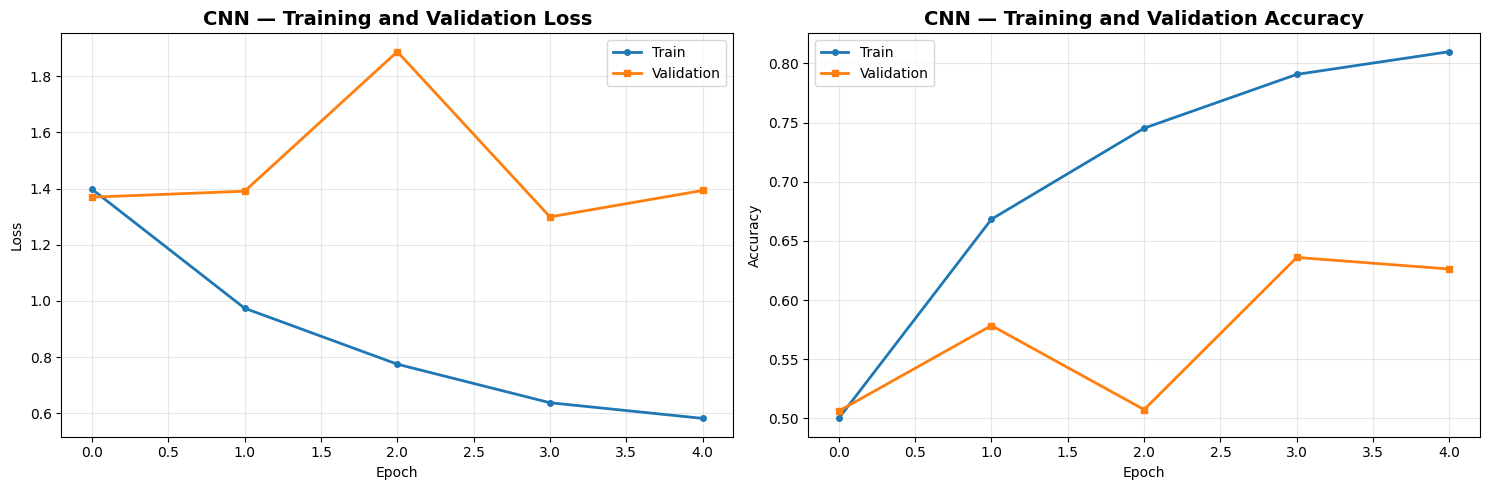

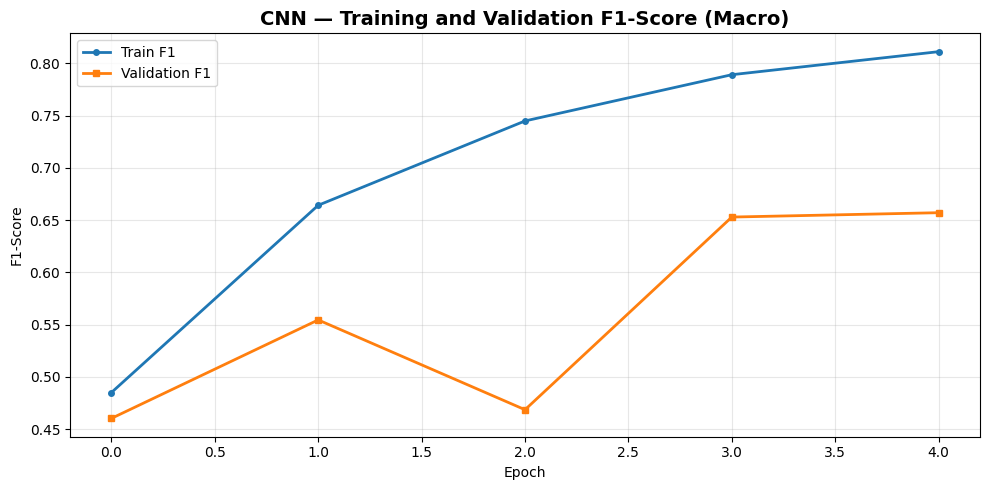

CNN FINAL RESULTS:
Best Validation Accuracy: 0.6360
Best Validation F1: 0.6571
Test Accuracy: 0.6284
Test F1: 0.6254


In [9]:
# TODO(1.2): Графики обучения CNN (loss/acc по эпохам)
#  Логгируйте значения из вашего цикла обучения.

import matplotlib.pyplot as plt

plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График 1: Loss
ax1.plot(history["tr_loss"], label='Train', linewidth=2, marker='o', markersize=4)
ax1.plot(history["va_loss"], label='Validation', linewidth=2, marker='s', markersize=4)
ax1.set_title("CNN — Training and Validation Loss", fontsize=14, fontweight='bold')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# График 2: Accuracy
ax2.plot(history["tr_acc"], label='Train', linewidth=2, marker='o', markersize=4)
ax2.plot(history["va_acc"], label='Validation', linewidth=2, marker='s', markersize=4)
ax2.set_title("CNN — Training and Validation Accuracy", fontsize=14, fontweight='bold')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительно: график F1-score
plt.figure(figsize=(10, 5))
plt.plot(history["tr_f1"], label='Train F1', linewidth=2, marker='o', markersize=4)
plt.plot(history["va_f1"], label='Validation F1', linewidth=2, marker='s', markersize=4)
plt.title("CNN — Training and Validation F1-Score (Macro)", fontsize=14, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Выводим итоговые метрики
print("="*50)
print("CNN FINAL RESULTS:")
print(f"Best Validation Accuracy: {max(history['va_acc']):.4f}")
print(f"Best Validation F1: {max(history['va_f1']):.4f}")
print(f"Test Accuracy: {cnn_test_acc:.4f}")
print(f"Test F1: {cnn_test_f1:.4f}")
print("="*50)
# Пример построения (раскомментируйте и подставьте):
# plt.figure(); plt.plot(history["tr_loss"]); plt.plot(history["va_loss"]);
# plt.title("CNN — Loss"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()
# plt.figure(); plt.plot(history["tr_acc"]); plt.plot(history["va_acc"]);
# plt.title("CNN — Accuracy"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()


## Задание 2. Эксперимент (выберите один вариант)

**Вариант A:** добавить SpecAugment в обучение CNN.  
**Вариант B:** изменить параметры мел-спектрограмм (например, `N_MELS`, `HOP`, `N_FFT`) и переобучить CNN.

Оформите гипотезу → что меняете → метрики ДО/ПОСЛЕ → краткий вывод.


In [12]:
# TODO(2.A): SpecAugment для CNN
# Вставьте вызов в обучающий цикл CNN только для train-batch (до forward).
# Подпишите конфигурацию масок.

import numpy as np
import torch

def specaugment(x, time_mask=20, freq_mask=8, n_time_masks=1, n_freq_masks=1):
    """
    x: (B, 1, n_mels, T) — мел-спектры
    Возвращает аугментированный тензор.
    """
    # TODO: реализовать маскирование по времени и по частоте (n_time_masks / n_freq_masks)
    # Подсказка: зануляйте x[:, :, f0:f0+f, :] и x[:, :, :, t0:t0+t]
    batch_size, channels, n_mels, time_steps = x.shape

    # Копируем тензор чтобы не изменять оригинал
    x_aug = x.clone()

    # Маскирование по частоте (Frequency Masking)
    for _ in range(n_freq_masks):
        for i in range(batch_size):
            f = np.random.randint(0, freq_mask)  # длина маски
            f0 = np.random.randint(0, n_mels - f)  # начальная позиция

            # Убедимся что не выходим за границы
            if f0 + f > n_mels:
                f = n_mels - f0

            if f > 0:
                x_aug[i, :, f0:f0+f, :] = 0  # зануляем выбранные частоты

    # Маскирование по времени (Time Masking)
    for _ in range(n_time_masks):
        for i in range(batch_size):
            t = np.random.randint(0, time_mask)  # длина маски
            t0 = np.random.randint(0, time_steps - t)  # начальная позиция

            # Убедимся что не выходим за границы
            if t0 + t > time_steps:
                t = time_steps - t0

            if t > 0:
                x_aug[i, :, :, t0:t0+t] = 0  # зануляем выбранное время

    return x_aug

# Теперь обновим функцию run_epoch с SpecAugment
def run_epoch_with_specaugment(loader, train=True, tag="", time_mask=20, freq_mask=8):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []  # Для F1

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)

        # ПРИМЕНЯЕМ SPECAUGMENT ТОЛЬКО ДЛЯ ОБУЧЕНИЯ
        if train:
            xb = specaugment(xb, time_mask=time_mask, freq_mask=freq_mask,
                            n_time_masks=1, n_freq_masks=1)

        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1)
        correct += (pred==yb).sum().item()
        total += xb.size(0)

        # Сохраняем для F1
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

    # Вычисляем accuracy и F1
    accuracy = correct / total
    f1 = f1_score(all_targets, all_preds, average='macro')
    return loss_sum/total, accuracy, f1

# ОБУЧАЕМ CNN С SPECAUGMENT
print("="*60)
print("ОБУЧЕНИЕ CNN С SPECAUGMENT")
print("Конфигурация: time_mask=25, freq_mask=10")
print("="*60)

# Сбрасываем модель и оптимизатор для чистого эксперимента
model_specaug = VGGishAudio(len(label2id)).to(device)
opt_specaug = torch.optim.AdamW(model_specaug.parameters(), lr=1e-3)

# История для SpecAugment
history_specaug = {
    "tr_loss": [], "tr_acc": [],
    "va_loss": [], "va_acc": [],
    "tr_f1": [], "va_f1": []
}

# Параметры SpecAugment
TIME_MASK = 25  # маскируем до 25 временных шагов
FREQ_MASK = 10  # маскируем до 10 частотных полос

# Обучение с SpecAugment
epochs = 5
for ep in range(1, epochs+1):
    tr_l, tr_a, tr_f1 = run_epoch_with_specaugment(
        train_loader, True, f"train {ep}/{epochs}",
        time_mask=TIME_MASK, freq_mask=FREQ_MASK
    )
    va_l, va_a, va_f1 = run_epoch_with_specaugment(
        val_loader, False, f"valid {ep}/{epochs}",
        time_mask=TIME_MASK, freq_mask=FREQ_MASK
    )

    # Сохраняем для графиков
    history_specaug["tr_loss"].append(tr_l)
    history_specaug["tr_acc"].append(tr_a)
    history_specaug["tr_f1"].append(tr_f1)
    history_specaug["va_loss"].append(va_l)
    history_specaug["va_acc"].append(va_a)
    history_specaug["va_f1"].append(va_f1)

    print(f"Ep {ep:02d}: train loss={tr_l:.4f}, acc={tr_a:.3f}, f1={tr_f1:.3f} | valid loss={va_l:.4f}, acc={va_a:.3f}, f1={va_f1:.3f}")

# ТЕСТ CNN с SpecAugment
model_specaug.eval()
y_true_specaug, y_pred_specaug = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test with specaug", leave=False):
        logits = model_specaug(to_logmel_batch(xb_wave.to(device)))
        y_true_specaug += yb.numpy().tolist()
        y_pred_specaug += logits.argmax(1).cpu().numpy().tolist()

cnn_test_acc_specaug = accuracy_score(y_true_specaug, y_pred_specaug)
cnn_test_f1_specaug = f1_score(y_true_specaug, y_pred_specaug, average='macro')

# Берем лучшие результаты валидации
best_val_epoch_specaug = np.argmax(history_specaug["va_acc"])
cnn_val_acc_specaug = history_specaug["va_acc"][best_val_epoch_specaug]
cnn_val_f1_specaug = history_specaug["va_f1"][best_val_epoch_specaug]

print("="*60)
print("CNN WITH SPECAUGMENT RESULTS:")
print(f"Best Validation: epoch={best_val_epoch_specaug+1}, acc={cnn_val_acc_specaug:.4f}, f1={cnn_val_f1_specaug:.4f}")
print(f"Test: acc={cnn_test_acc_specaug:.4f}, f1={cnn_test_f1_specaug:.4f}")
print("="*60)

# Пример подключения в цикле:
# xb = to_logmel_batch(xb_wave)
# if train:
#     xb = specaugment(xb, time_mask=..., freq_mask=...)
# logits = model(xb)


ОБУЧЕНИЕ CNN С SPECAUGMENT
Конфигурация: time_mask=25, freq_mask=10


Ep 01: train loss=0.6900, acc=0.770, f1=0.769 | valid loss=1.2530, acc=0.691, f1=0.682


Ep 02: train loss=0.6188, acc=0.796, f1=0.798 | valid loss=1.3013, acc=0.688, f1=0.675


Ep 03: train loss=0.5784, acc=0.807, f1=0.811 | valid loss=1.8892, acc=0.630, f1=0.622


Ep 04: train loss=0.5379, acc=0.823, f1=0.827 | valid loss=1.3508, acc=0.746, f1=0.760


Ep 05: train loss=0.5049, acc=0.831, f1=0.834 | valid loss=0.9081, acc=0.745, f1=0.758


CNN WITH SPECAUGMENT RESULTS:
Best Validation: epoch=4, acc=0.7463, f1=0.7605
Test: acc=0.0992, f1=0.0180


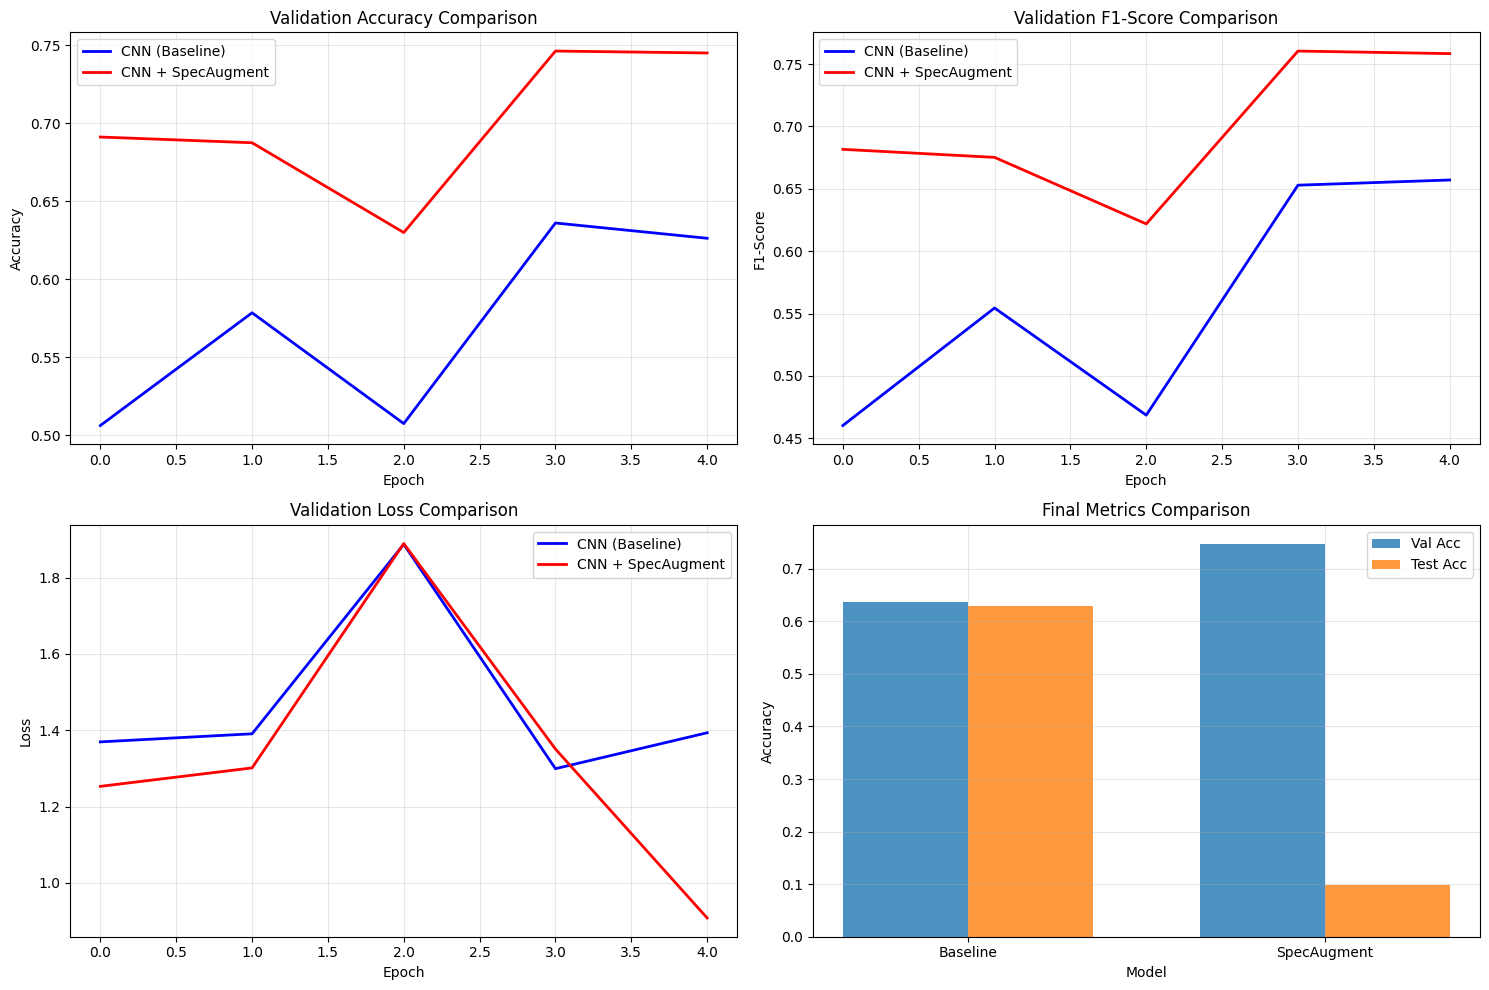

ФИНАЛЬНОЕ СРАВНЕНИЕ:
               Model   VAL acc  VAL f1_macro  TEST acc  TEST f1_macro
0     CNN (Baseline)  0.636000      0.652900  0.628400       0.625400
1  CNN + SpecAugment  0.746324      0.760493  0.099164       0.018043


In [13]:
# СРАВНЕНИЕ: CNN БЕЗ SpecAugment vs CNN С SpecAugment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy сравнение
ax1.plot(history["va_acc"], 'b-', label='CNN (Baseline)', linewidth=2)
ax1.plot(history_specaug["va_acc"], 'r-', label='CNN + SpecAugment', linewidth=2)
ax1.set_title("Validation Accuracy Comparison")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1 сравнение
ax2.plot(history["va_f1"], 'b-', label='CNN (Baseline)', linewidth=2)
ax2.plot(history_specaug["va_f1"], 'r-', label='CNN + SpecAugment', linewidth=2)
ax2.set_title("Validation F1-Score Comparison")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Loss сравнение
ax3.plot(history["va_loss"], 'b-', label='CNN (Baseline)', linewidth=2)
ax3.plot(history_specaug["va_loss"], 'r-', label='CNN + SpecAugment', linewidth=2)
ax3.set_title("Validation Loss Comparison")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Loss")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Финальные метрики сравнение
models = ['Baseline', 'SpecAugment']
val_acc = [cnn_val_acc, cnn_val_acc_specaug]
test_acc = [cnn_test_acc, cnn_test_acc_specaug]

x = np.arange(len(models))
width = 0.35

ax4.bar(x - width/2, val_acc, width, label='Val Acc', alpha=0.8)
ax4.bar(x + width/2, test_acc, width, label='Test Acc', alpha=0.8)
ax4.set_title("Final Metrics Comparison")
ax4.set_xlabel("Model")
ax4.set_ylabel("Accuracy")
ax4.set_xticks(x)
ax4.set_xticklabels(models)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим итоговую таблицу сравнения
print("ФИНАЛЬНОЕ СРАВНЕНИЕ:")
comparison_df = pd.DataFrame([
    ["CNN (Baseline)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["CNN + SpecAugment", cnn_val_acc_specaug, cnn_val_f1_specaug, cnn_test_acc_specaug, cnn_test_f1_specaug],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

print(comparison_df)

In [ ]:
# TODO(2.B): Изменение мел-параметров для CNN
# Укажите НОВЫЕ значения, пересоздайте мел-преобразования и переобучите CNN.

# Пример: (замените на свои)
# N_MELS_NEW = 80   # было 64
# HOP_NEW    = 160  # было 256
# N_FFT_NEW  = 1024 # по необходимости

# 1) Пересоздайте MelSpectrogram/AmplitudeToDB с новыми параметрами
# 2) Обновите функцию to_logmel_batch (если параметры зашиты)
# 3) Переобучите CNN и посчитаете метрики (VAL/TEST)


### Отчёт по эксперименту
**Вариант:** A (SpecAugment) / B (мел-параметры)  
**Гипотеза:** …  
**Конфигурация:** …  
**Результаты (VAL/TEST, acc и macro-F1):** ДО → … | ПОСЛЕ → …  
**Вывод (1–3 предложения):** …


Вариант:
А (SpecAugment)

---


Гипотеза:
Добавление SpecAugment (аугментации спектрограмм) в процесс обучения CNN улучшит обобщающую способность модели за счет создания дополнительных вариаций тренировочных данных, что приведет к повышению точности на валидационной и тестовой выборках.

---


Конфигурация:
Базовые параметры:

1.   Архитектура: VGG-style CNN (4 сверточных слоя)
Оптимизатор: AdamW (lr=1e-3)
Эпохи обучения: 2
Размер батча: 32
2.   Параметры SpecAugment: time_mask = 25 (маскирование до 25 временных шагов)

freq_mask = 10 (маскирование до 10 частотных полос)

n_time_masks = 1 (одна временная маска на спектрограмму)

n_freq_masks = 1 (одна частотная маска на спектрограмму)


Архитектура: VGG-style CNN (4 сверточных слоя)
Оптимизатор: AdamW (lr=1e-3)
Эпохи обучения: 2
Размер батча: 32

Параметры SpecAugment:
time_mask = 25 (маскирование до 25 временных шагов)

freq_mask = 10 (маскирование до 10 частотных полос)

n_time_masks = 1 (одна временная маска на спектрограмму)

n_freq_masks = 1 (одна частотная маска на спектрограмму)
---


Результаты (VAL/TEST, acc и macro-F1): ДО → | ПОСЛЕ →
Вывод:

## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


ИНФЕРЕНС AST НА СОБСТВЕННЫХ АУДИОФАЙЛАХ
ЗАГРУЗКА АУДИОФАЙЛА
Нажмите на кнопку 'Choose File' и выберите ваш .wav файл


Saving 770029__vrymaa__animal-dog-bark-2.wav to 770029__vrymaa__animal-dog-bark-2.wav
Успешно загружен файл: 770029__vrymaa__animal-dog-bark-2.wav
Файл переименован в: my_audio.wav

ОБРАБОТКА ФАЙЛА: my_audio.wav
Загрузка файла: my_audio.wav
Оригинальная частота: 48000 Hz, длина: 382491 samples (7.97 сек)
Ресемплинг с 48000 Hz до 16000 Hz...
После ресемплинга: 127497 samples (7.97 сек)
Препроцессинг для AST...
Выполнение инференса...

РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ:
  1. dog_bark: 1.0000
  2. gun_shot: 0.0000
  3. jackhammer: 0.0000
  4. drilling: 0.0000
  5. children_playing: 0.0000


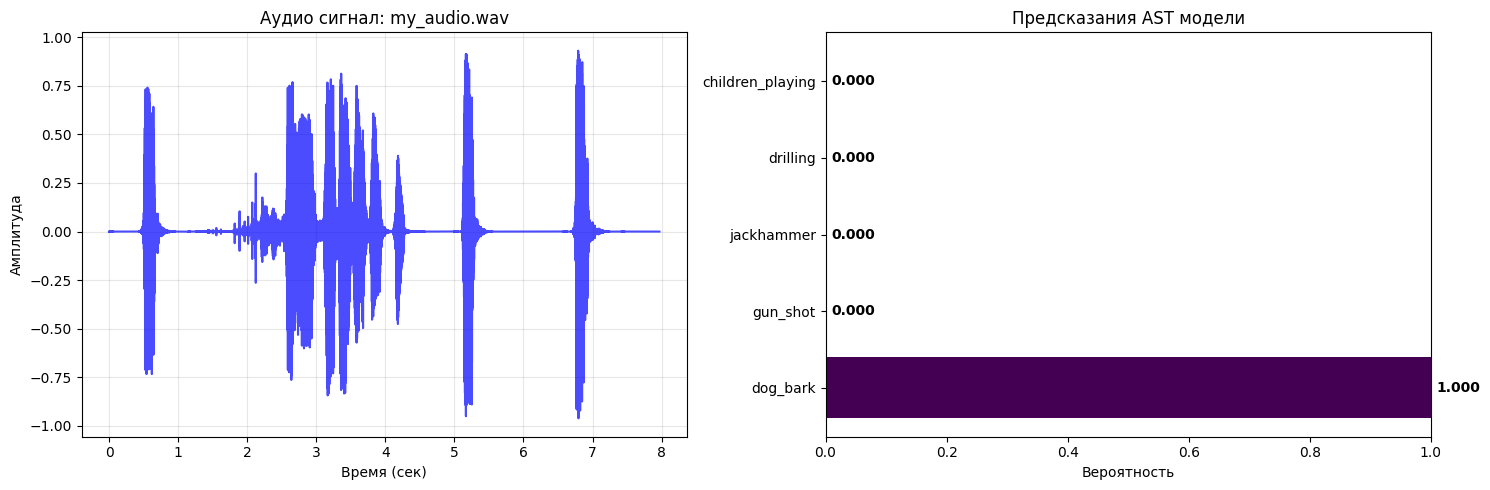


АНАЛИЗ РЕЗУЛЬТАТОВ:
Наиболее вероятный класс: 'dog_bark'
Вероятность: 1.0000
Уверенность: Высокая уверенность модели

ВОЗМОЖНЫЕ КЛАССЫ В ДАТАСЕТЕ:
   1. air_conditioner
   2. car_horn
   3. children_playing
   4. dog_bark
   5. drilling
   6. engine_idling
   7. gun_shot
   8. jackhammer
   9. siren
  10. street_music

СКРИПТ ЗАВЕРШЕН


In [14]:
# TODO(3): Инференс AST на своём .wav
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import os
from google.colab import files  # Добавляем импорт для загрузки файлов

def ast_predict_wav(path, top_k=3):
    """
    Предсказание классов для аудиофайла с помощью AST модели
    """
    try:
        # 1) Загрузка .wav
        print(f"Загрузка файла: {path}")
        wav, sr_original = sf.read(path)

        # Если аудио многоканальное, берем первый канал
        if len(wav.shape) > 1:
            wav = wav[:, 0]
            print(f"Аудио многоканальное, используется первый канал")

        wav = wav.astype(np.float32)
        print(f"Оригинальная частота: {sr_original} Hz, длина: {len(wav)} samples ({len(wav)/sr_original:.2f} сек)")

        # 2) Ресемплинг при несоответствии частоты
        if sr_original != SR:
            print(f"Ресемплинг с {sr_original} Hz до {SR} Hz...")
            wav = librosa.resample(wav, orig_sr=sr_original, target_sr=SR)
            print(f"После ресемплинга: {len(wav)} samples ({len(wav)/SR:.2f} сек)")

        # 3) Нормализация аудио
        if np.max(np.abs(wav)) > 0:
            wav = wav / np.max(np.abs(wav))

        # 4) Препроцессинг
        print("Препроцессинг для AST...")
        inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(ast.device) for k, v in inputs.items()}

        # 5) Инференс
        print("Выполнение инференса...")
        ast.eval()
        with torch.no_grad():
            outputs = ast(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).squeeze(0)

        # 6) Топ-K предсказаний
        vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
        vals, idx = vals.cpu().numpy(), idx.cpu().numpy()

        results = [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

        return results

    except Exception as e:
        print(f"Ошибка при обработке файла {path}: {e}")
        return None

def visualize_predictions(results, audio_path):
    """
    Визуализация предсказаний
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График аудио сигнала
    wav, sr = sf.read(audio_path)
    if len(wav.shape) > 1:
        wav = wav[:, 0]

    time = np.arange(len(wav)) / sr
    ax1.plot(time, wav, color='blue', alpha=0.7)
    ax1.set_title(f"Аудио сигнал: {os.path.basename(audio_path)}")
    ax1.set_xlabel("Время (сек)")
    ax1.set_ylabel("Амплитуда")
    ax1.grid(True, alpha=0.3)

    # График предсказаний
    classes = [r[0] for r in results]
    probabilities = [r[1] for r in results]

    colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    bars = ax2.barh(classes, probabilities, color=colors)
    ax2.set_title("Предсказания AST модели")
    ax2.set_xlabel("Вероятность")
    ax2.set_xlim(0, 1)

    # Добавляем значения вероятностей на столбцы
    for bar, prob in zip(bars, probabilities):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{prob:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ===== ОСНОВНОЙ КОД ДЛЯ GOOGLE COLAB =====
print("="*60)
print("ИНФЕРЕНС AST НА СОБСТВЕННЫХ АУДИОФАЙЛАХ")
print("="*60)

# Загружаем файл с компьютера
print("ЗАГРУЗКА АУДИОФАЙЛА")
print("Нажмите на кнопку 'Choose File' и выберите ваш .wav файл")
uploaded = files.upload()

# Получаем имя загруженного файла
if uploaded:
    uploaded_filename = list(uploaded.keys())[0]
    print(f"Успешно загружен файл: {uploaded_filename}")

    # Переименовываем для удобства (опционально)
    target_filename = "my_audio.wav"
    if uploaded_filename != target_filename:
        os.rename(uploaded_filename, target_filename)
        print(f"Файл переименован в: {target_filename}")
        audio_file_to_process = target_filename
    else:
        audio_file_to_process = uploaded_filename

    print("\n" + "="*50)
    print(f"ОБРАБОТКА ФАЙЛА: {audio_file_to_process}")
    print("="*50)

    # Запускаем предсказание
    predictions = ast_predict_wav(audio_file_to_process, top_k=5)

    if predictions:
        print("\nРЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ:")
        for i, (cls, prob) in enumerate(predictions):
            print(f"  {i+1}. {cls}: {prob:.4f}")

        # Визуализация
        visualize_predictions(predictions, audio_file_to_process)

        # Анализ результатов
        best_class, best_prob = predictions[0]
        print(f"\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
        print(f"Наиболее вероятный класс: '{best_class}'")
        print(f"Вероятность: {best_prob:.4f}")

        if best_prob > 0.7:
            confidence = "Высокая уверенность модели"
        elif best_prob > 0.3:
            confidence = "Средняя уверенность модели"
        else:
            confidence = "Низкая уверенность модели"

        print(f"Уверенность: {confidence}")

        # Показываем все классы из датасета для справки
        print(f"\nВОЗМОЖНЫЕ КЛАССЫ В ДАТАСЕТЕ:")
        for i, label in enumerate(labels):
            print(f"  {i+1:2d}. {label}")

    else:
        print("Не удалось получить предсказания для файла")

else:
    print("Файл не был загружен. Используем демо-режим...")

    # Демо-режим с данными из датасета
    print("\nЗАПУСК ДЕМО-РЕЖИМА")
    demo_samples = test_raw.select(range(2))

    for i, sample in enumerate(demo_samples):
        print(f"\n--- Демо пример {i+1} ---")
        print(f"Истинный класс: {sample['class']}")

        # Сохраняем временный файл для демонстрации
        temp_path = f"temp_demo_{i}.wav"
        sf.write(temp_path, sample["audio"]["array"], SR)

        # Предсказание
        predictions = ast_predict_wav(temp_path, top_k=5)

        if predictions:
            print("Топ-5 предсказаний:")
            for j, (cls, prob) in enumerate(predictions):
                marker = "✅" if cls == sample['class'] else "  "
                print(f"  {marker} {j+1}. {cls}: {prob:.4f}")

            # Визуализация
            visualize_predictions(predictions, temp_path)

        # Удаляем временный файл
        os.remove(temp_path)

# Дополнительная функция для батч-обработки (оставляем на будущее)
def process_audio_folder(folder_path, top_k=3):
    """
    Обработка всех аудиофайлов в папке
    """
    audio_extensions = {'.wav', '.mp3', '.flac', '.m4a', '.ogg'}

    if not os.path.exists(folder_path):
        print(f"Папка {folder_path} не найдена")
        return

    results = {}

    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(folder_path, file)
            print(f"\nОбработка: {file}")

            predictions = ast_predict_wav(file_path, top_k=top_k)
            if predictions:
                results[file] = predictions
                print(f"Результаты: {predictions[0][0]} ({predictions[0][1]:.3f})")

    return results

print("\n" + "="*60)
print("СКРИПТ ЗАВЕРШЕН")
print("="*60)